NOTES
- profile of salinity width perhaps assume 50 m or 100 m wide??
- residence time is dependednt on M2 tidal component meaning every 12 hrs water moves 2 km, 0.1 m/sec


In [1]:
# IMport modules 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

# set options 
pd.set_option('display.max_rows', 6100)  

pd.set_option('mode.chained_assignment', None)

pd.options.display.float_format = '{:,.3f}'.format

In [2]:
!pip install geopandas
import geopandas as gpd

     |████████████████████████████████| 972kB 3.4MB/s 
     |████████████████████████████████| 14.7MB 309kB/s 
     |████████████████████████████████| 10.9MB 19.5MB/s 


In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

os.chdir('Shared drives/Attias_ER-to-SGD/Scripts')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


### Calculate salinity from conductivity function 


Look into this function more for accuracy?????


In [8]:
# from https://github.com/jsta/cond2sal_shiny/blob/master/helpers.R

def cond2sal(c, t = 27.5, P = 0):          # c in (uS/cm)
    a0 = 0.008
    a1 = -0.1692
    a2 = 25.3851
    a3 = 14.0941
    a4 = -7.0261
    a5 = 2.7081
    b0 = 5e-04
    b1 = -0.0056
    b2 = -0.0066
    b3 = -0.0375
    b4 = 0.0636
    b5 = -0.0144
    c0 = 0.6766097
    c1 = 0.0200564
    c2 = 0.0001104
    c3 = -6.9698e-07
    c4 = 1.0031e-09
    D1 = 0.03426
    D2 = 0.0004464
    D3 = 0.4215
    D4 = -0.003107
    e1 = 0.000207
    e2 = -6.37e-08
    e3 = 3.989e-12
    Csw = 42.914
    K = 0.0162
    
    Ct = round(c * (1 + 0.0191 * (t - 25)), 0)
    R = (Ct/1000)/Csw
    rt = c0 + (t * c1) + (t**2 * c2) + (t**3 * c3) + (t**4 * c4)
    Rp = 1 + (P * e1 + e2 * P**2 + e3 * P**3)/(1 + D1 * t + D2 * t**2 + (D3 + D4 * t) * R)
    Rt1 = R/(Rp * rt)
    dS = (b0 + b1 * Rt1**(1/2) + b2 * Rt1**(2/2) + b3 * Rt1**(3/2) + b4 * Rt1**(4/2) + b5 * Rt1**(5/2)) * (t - 15)/(1 + K * (t - 15))
    S = a0 + a1 * Rt1**(1/2) + a2 * Rt1**(2/2) + a3 * Rt1**(3/2) + a4 * Rt1**(4/2) + a5 * Rt1**(5/2) + dS
    
    return(S)

### Calculate conductivity from resistivity function

##### Note that 

 - Dataset OHM-m range 28.935 to 0.10685   
 - seawater has conductivity of around 54000 µS/cm
 
- ohmM_to_uSpcm(0.10685 ) = 93589.
- and 
- ohmM_to_uSpcm(28.935) =  345.6 
    
#### unit conversions notes
1 ohm-m = 1 S/m  
1 S/m = 10000 uS/cm

https://www.cactus2000.de/uk/unit/masscnd.php
https://www.translatorscafe.com/unit-converter/en-US/electric-conductivity/12-10/microsiemens/meter-millisiemens/meter/

http://salinometry.com/pss-78/

In [4]:
def ohmM_to_uSpcm(ohmMs):
    
    SiemensPerMeter = (1/ohmMs)
    uSpcm = SiemensPerMeter*10000
    
    return uSpcm

In [10]:
cond2sal(ohmM_to_uSpcm(.5))

11.883773056308703

# Data Paths

In [ ]:
# paths to data
datapath =  os.path.join("..", "Raw_Data", "Freshwater_Plumes_lines_information_for_Chris")
bathydata_path = os.path.join(datapath, 'Bathymetrylines_raw')

hi_res_datapath = os.path.join("..", "Raw_Data", "Higher_resolution_data")

# path to the temp folder
workspace = os.path.join("..", 'Workspace')

# Some containers to house results

In [ ]:
profile_name_list = []
Tot_vol_FW_1m_rez_list = []
pct_FW_list = []
Notes_List =[]

## Functions to perform various analysis tasks

In [ ]:
# Read in resistivity profile Funciton

def Read_in_resistivity_profile(data_in):

    data = data_in.copy()

    # Convert the resistivity into conductivity and salinity
    data['Salinity'] = data['Resistivity'].apply(lambda x: cond2sal(ohmM_to_uSpcm(x)))
    data['Conductivity_uSpcm'] = data['Resistivity'].apply(lambda x: ohmM_to_uSpcm(x))

    # More fun columns, Pressure and temp correct the salinity data. not that it matters.
    data['Pressure_dBar'] = 0.9796855684*data['D']     # pressure in decibars at depth
    data['Est_temp_degC'] = 27.5-.07*data['D']         # Estimated linear temperature gradient emperically designed to make temp at 100m 20degC
    data['Salinity_PT_corrected'] = data.apply(lambda row: cond2sal(ohmM_to_uSpcm(row['Resistivity']), t=row['Est_temp_degC'], P=row['Pressure_dBar'] ), axis=1)

    # calculate the x-distance which is the distance along a profile starting at the first easting/northing point
    StartX = data['E'][0]
    StartY = data['N'][0]
    data["Xdistance"] = np.sqrt((data["E"]-StartX)**2 + (data["N"]-StartY)**2)

    # Also create a rounded version to use for tacking on bathymetry data
    data['Xdistance_int'] = data['Xdistance'].apply(lambda x: round(x))

    # If the depths are not negative numbers, make them be negative
    data['D'] =  data['D']*-1

    # Plot the whole profile as a scatter plot to look see
    fig, ax = plt.subplots(figsize =(15,5))
    plt.scatter(data['Xdistance'], data['D'], c=data['Conductivity_uSpcm'], cmap=plt.cm.jet, label=plt.cm.jet )
    plt.title("Raw scatterplot of conductivity data")

    return data

In [ ]:
# Read in bathymetry profile Functon 

def Tack_on_Bathydata(profile_data_in, bathymetry_data_in):

    bathydata = bathymetry_data_in.copy()

    #bathydata = bathydata.reset_index()
    bathydata['Tot_Distance'] = bathydata['distance']-bathydata['distance'][0]
    bathydata['Tot_Distance_int'] = bathydata['Tot_Distance'].apply(lambda x: round(x))

    bathydata_interpolate = pd.DataFrame({'Tot_Distance_int':list(range(0,bathydata['Tot_Distance_int'].max()))})
    bathydata_interpolate = bathydata_interpolate.merge(bathydata, on='Tot_Distance_int', how='outer')                                                                    

    bathydata_interpolate = bathydata_interpolate.interpolate()
    bathydata_interpolate = bathydata_interpolate.rename(columns={'Tot_Distance_int': 'Xdistance_int'})

    profile_data_in = profile_data_in.merge(bathydata_interpolate, on='Xdistance_int', how="left")

    data_bath = profile_data_in.copy()

    data_bath= data_bath[data_bath['floor Depth']*-1 < data_bath['D']]
 
    return data_bath

# Note Problem as the length of the bathymetry file seems to be 2998.983900, whereas the resistivity corss section is 2249.581739 so just using the start value here 

In [ ]:
def Calc_fractions_in_plume(data, cell_height):

    """
    function to take a resistivity profile and calc the % of fresh vs saltwater
    """

    data4 = data.copy()
    data5 = pd.DataFrame()    # create empty DF to house final DF

    startdist = data4['Xdistance'].min()
    data4['datumXdistance'] = data4['Xdistance'] + (-startdist)

    data4["cell_height"] = cell_height   # each cell seems to be 2 m high
 
    for i in data4['D'].unique():           # For each "row" of depth values
        tempframe = data4[data4['D'] == i]  # 
        tempframe.reset_index(inplace=True, drop=True) 

        tempframe['dA'] = abs(tempframe['datumXdistance'].shift(-1) - tempframe['datumXdistance'])/2 # distance between point and the last one then over 2 to calc dist from point to cell edge
        tempframe['dB'] = abs(tempframe['datumXdistance'].shift(1) - tempframe['datumXdistance'])/2  # distance between point and the next one then over 2 to calc dist from point to cell edge
        tempframe['cell_width'] = tempframe['dA'].median()+tempframe['dB'].median()

        data5 = pd.concat([data5,tempframe])

    # Calculate profile volumes 
    data5['cell_unit_area'] =data5['cell_height'] * data5['cell_width']
    data5['cell_FW_fraction'] = 1-data5['Salinity_PT_corrected']/35    #  35 is salinity of ocean
    data5['cell_FW_volume_m3'] = data5['cell_FW_fraction']*data5['cell_unit_area']

    TOT_FW_Vol_m3 =  data5['cell_FW_volume_m3'].sum()
    TOT_profile_Vol_m3 =  data5['cell_unit_area'].sum()
    pct_FW = TOT_FW_Vol_m3/TOT_profile_Vol_m3*100


    # Plot the whole profile as a scatter plot to look see
    fig, ax = plt.subplots(figsize =(10,5))
    plt.scatter(data5['datumXdistance'], data5['D'], c=data5['Salinity_PT_corrected'], cmap=plt.cm.jet, label=plt.cm.jet )
    plt.title("Bathymetry included scatterplot of Salinity_PT_corrected data")
    plt.legend()
    
    return data5, TOT_profile_Vol_m3, pct_FW

In [ ]:
# def simple sanity check function 

def sanity_check(data_in):
    print('SANITY CHECK')

    Unrealistic_hi = data_in[data_in['Conductivity_uSpcm'] >54000]
    print("Percent of data that is unrealistically high salinity {:.2f}%".format(100*len(Unrealistic_hi)/len(data_in)))

    # Check how much of the resistiviy value if directly translated to a salinity of of a kind of crazy value to be in the ocean
    Very_low = data_in[data_in['Conductivity_uSpcm'] < 2000]
    print("Percent of data that is crazy low salinity < 1 is {:.2f}%  \n".format(100*len(Very_low)/len(data_in)))


    # Back of envelope calculations
    print("Back of envelope calculations to check validity: ")
    Sanity_check_Pro_vol = data_in['datumXdistance'].max()  * abs(data_in['D']).max()
    print("Profile Length is {:,.1f}m, profile Depth is {:,.1f}m ".format(data_in['datumXdistance'].max(),abs(data_in['D']).max()))                                                                    
    print("Tot profile unit volumne   {:,.1f}m3 ".format(Sanity_check_Pro_vol))                   
    Ave_profile_sal = data_in['Salinity_PT_corrected'].mean() 
    ave_freshwater_frac = 1-Ave_profile_sal/35
    print("Average profile salinity is {:.1f}, meaning average freshwater fraction is {:.4f}".format(Ave_profile_sal, ave_freshwater_frac))
    print("Total vol of FW (L x D x aveFWF) is  = {:,.1f} m3  \n".format(Sanity_check_Pro_vol*ave_freshwater_frac))

    # Cell by cell calulated results
    print("\nCompare to cell by cell calculated results:") 
    print("Number of cells is {:,.1f} with mean volumne of {:,.1f}".format(len(data_in['cell_unit_area']), data_in['cell_unit_area'].mean()))
    print("Tot profile unit volumne from adding cells  {:,.2f}m3 ".format(data5_Corrected['cell_unit_area'].sum()))
    print("Average freshwater fraction in the cell by cell profile is {:,.2f}".format(data_in['cell_FW_fraction'].mean()))
    print("Compare to cell by cell calculated total profile freshwater volume of {:,.1f}m3".format(data5_Corrected['cell_FW_volume_m3'].sum()))



# Execute On data Profiles

# A: Execute analysis on 3.Line3aSegment2MainPlume


SANITY CHECK
Percent of data that is unrealistically high salinity 14.87%
Percent of data that is crazy low salinity < 1 is 1.72%  

Back of envelope calculations to check validity: 
Profile Length is 2,249.6m, profile Depth is 96.0m 
Tot profile unit volumne   215,959.8m3 
Average profile salinity is 19.3, meaning average freshwater fraction is 0.4499
Total vol of FW (L x D x aveFWF) is  = 97,167.5 m3  


Compare to cell by cell calculated results:
Number of cells is 50,679.0 with mean volumne of 4.2
Tot profile unit volumne from adding cells  212,824.71m3 
Average freshwater fraction in the cell by cell profile is 0.45
Compare to cell by cell calculated total profile freshwater volume of 95,747.5m3


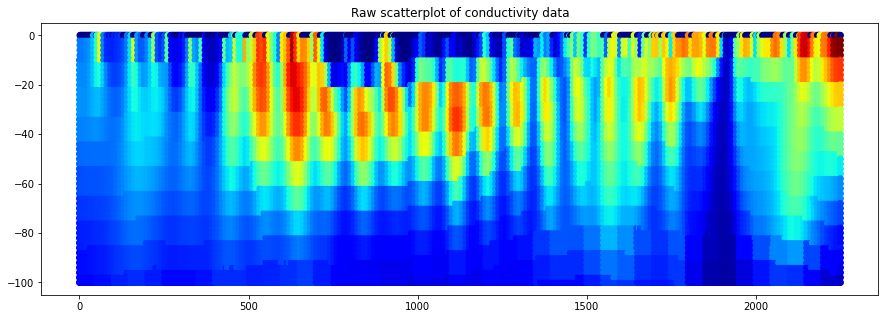

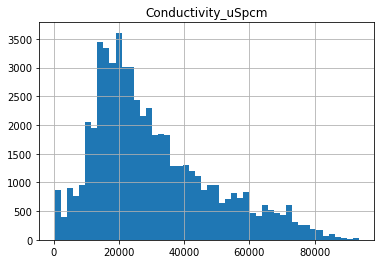

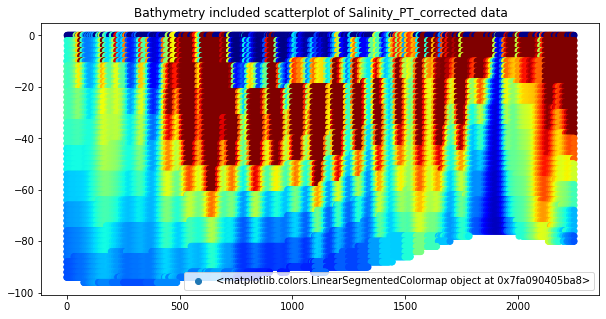

In [ ]:
# Step 1: Read in data 
data_L3aS2 = pd.read_csv(os.path.join(datapath, '3.Line3aSegment2MainPlume', "Line3a_Segment2.txt"), 
                   sep = " ", index_col=False)
# Execute function above
data1 = Read_in_resistivity_profile(data_L3aS2)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)



# Step 2: Read in bathydata and tack on data 
names = ["distance", "floor Depth"]
bathydata_in = pd.read_csv(os.path.join(bathydata_path, "Line3a_Segment 2_bathy.txt"),
                        delim_whitespace=True, usecols=[0,1], names=names, skiprows=1, index_col=False)

data_bath = Tack_on_Bathydata(data1, bathydata_in)


# Step 3: sanity checks and fix over salinity values
# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity_PT_corrected'] > 35, 'Salinity_PT_corrected'] = 35


# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)

# Step 5:  save resulting points as shapefiles
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "Line3a_Segment2_Profile.shp"), driver='ESRI Shapefile')  #write shapefile

# Step 6 Sanity check results
sanity_check(data5_Corrected)

# Append Results 
profile_name_list.append("Line3a_Segment2_Profile.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Problem as the length of the bathymetry file seems to be 2998.983900, whereas the resistivity corss section is 2249.581739")


In [ ]:
data5_Corrected.columns

Index(['E', 'N', 'D', 'Resistivity', 'Salinity', 'Conductivity_uSpcm',
       'Pressure_dBar', 'Est_temp_degC', 'Salinity_PT_corrected', 'Xdistance',
       'Xdistance_int', 'distance', 'floor Depth', 'Tot_Distance',
       'datumXdistance', 'cell_height', 'dA', 'dB', 'cell_width',
       'cell_unit_area', 'cell_FW_fraction', 'cell_FW_volume_m3', 'geometry'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac47796780>]],
      dtype=object)

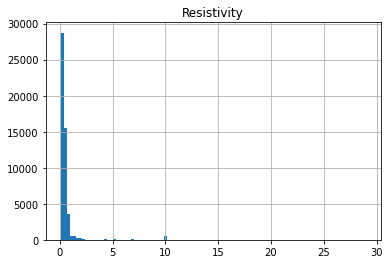

In [ ]:
# Check out histogram of data
data5_Corrected.hist(column='Resistivity', bins=100)

data5_Corrected['Resistivity'].describe()

# A2: Execute analysis on 3.Line3aSegment2MainPlume HI REZ veriosn

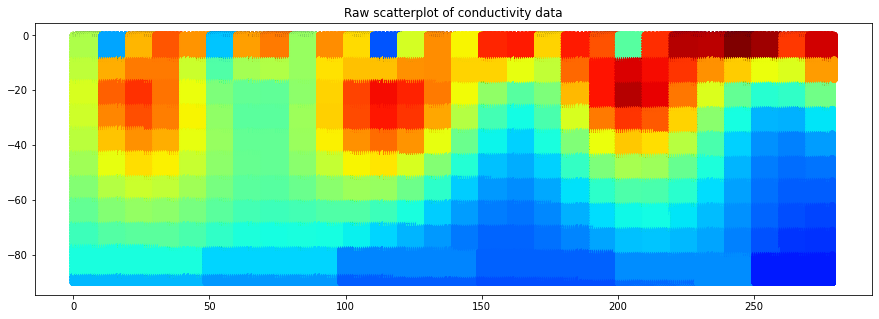

In [ ]:
# Step 1: Read in data 
data_L3aS2 = pd.read_csv(os.path.join(hi_res_datapath, "Line3a_Segment2_new2.txt"), 
                   sep = " ", index_col=False)

# Execute Read_in_resistivity_profile function 
data1 = Read_in_resistivity_profile(data_L3aS2)



In [ ]:
data1.describe()

,E,N,D,Resistivity,Salinity,Conductivity_uSpcm,Pressure_dBar,Est_temp_degC,Salinity_PT_corrected,Xdistance,Xdistance_int
count,"2,513,952.000","2,513,952.000","2,513,952.000","2,513,952.000","2,513,952.000","2,513,952.000","2,513,952.000","2,513,952.000","2,513,952.000","2,513,952.000","2,513,952.000"
mean,"811,479.184","2,195,491.230",-45.026,"5,584,832,168.787",23.848,"37,223.550",44.112,24.348,23.821,139.781,139.776
std,58.598,55.263,25.999,"236,256,541,787.039",11.042,"15,621.549",25.471,1.820,11.042,80.544,80.545
min,"811,378.000","2,195,395.000",-90.000,0.135,0.013,0.000,0.000,21.200,0.013,0.000,0.000
25%,"811,428.000","2,195,443.000",-67.000,0.202,14.309,"23,707.356",22.533,22.810,14.276,70.036,70.000
50%,"811,479.000","2,195,491.000",-45.000,0.285,22.002,"35,056.968",44.086,24.350,21.981,140.071,140.000
75%,"811,530.000","2,195,539.000",-23.000,0.422,32.251,"49,421.765",65.639,25.890,32.197,210.107,210.000
max,"811,581.000","2,195,587.000",0.000,"10,000,000,000,000.000",51.273,"74,321.813",88.172,27.500,51.273,279.415,279.000


Text(0.5, 1.0, 'Raw scatterplot of conductivity data')

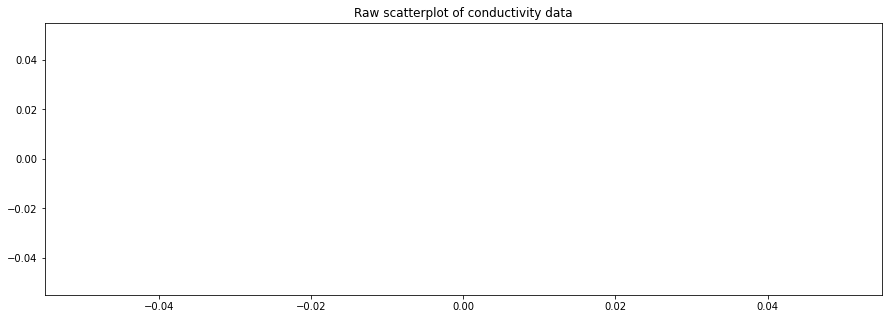

In [ ]:

# zoom in on a specfic part of the profile
data_plume = data1.copy()
data_plume = data_plume[(data_plume['Xdistance'] > 1765) & (data_plume['Xdistance'] < 2080) ]

# Plot the whole profile as a scatter plot to look see
fig, ax = plt.subplots(figsize =(15,5))
plt.scatter(data_plume['Xdistance'], data_plume['D'], c=data_plume['Conductivity_uSpcm'], cmap=plt.cm.jet, label=plt.cm.jet )
plt.title("Raw scatterplot of conductivity data")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa07b4a94e0>]],
      dtype=object)

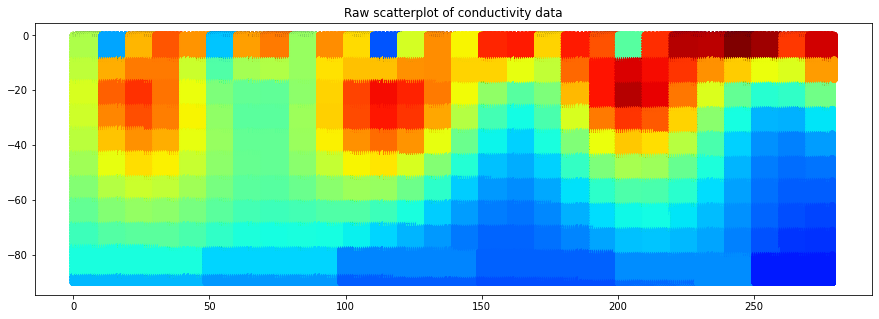

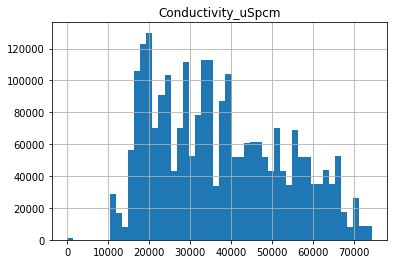

In [ ]:





# Step 1: Read in data 
data_L3aS2 = pd.read_csv(os.path.join(hi_res_datapath, "Line3a_Segment2_new2.txt"), 
                   sep = " ", index_col=False)




# Execute Read_in_resistivity_profile function 
data1 = Read_in_resistivity_profile(data_L3aS2)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)

In [ ]:
data1

,E,N,D,Resistivity,Salinity,Conductivity_uSpcm,Pressure_dBar,Est_temp_degC,Salinity_PT_corrected,Xdistance,Xdistance_int
0,811581,2195587,0,0.240,26.645,"41,659.723",0.000,27.500,26.645,0.000,0
1,811581,2195587,0,0.240,26.645,"41,659.723",0.000,27.500,26.645,0.000,0
2,811581,2195587,0,0.240,26.645,"41,659.723",0.000,27.500,26.645,0.000,0
3,811581,2195587,0,0.240,26.645,"41,659.723",0.000,27.500,26.645,0.000,0
4,811581,2195587,-1,0.240,26.645,"41,659.723",0.980,27.430,26.644,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...
2513947,811378,2195395,-16,0.181,36.587,"55,285.272",15.675,26.380,36.569,279.415,279
2513948,811378,2195395,-16,0.181,36.587,"55,285.272",15.675,26.380,36.569,279.415,279
2513949,811378,2195395,-16,0.181,36.587,"55,285.272",15.675,26.380,36.569,279.415,279
2513950,811378,2195395,-16,0.181,36.587,"55,285.272",15.675,26.380,36.569,279.415,279


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


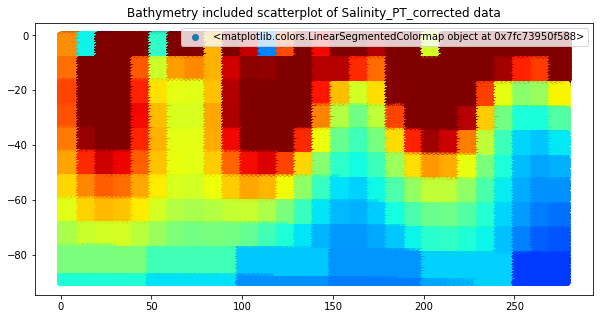

In [ ]:




# Step 2: Read in bathydata and tack on data 
names = ["distance", "floor Depth"]
bathydata_in = pd.read_csv(os.path.join(bathydata_path, "Line3a_Segment 2_bathy.txt"),
                        delim_whitespace=True, usecols=[0,1], names=names, skiprows=1, index_col=False)

data_bath = Tack_on_Bathydata(data1, bathydata_in)


# Step 3: sanity checks and fix over salinity values
# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity_PT_corrected'] > 35, 'Salinity_PT_corrected'] = 35

# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)

In [ ]:
# Step 6 Sanity check results
sanity_check(data5_Corrected)

SANITY CHECK
Percent of data that is unrealistically high salinity 18.35%
Percent of data that is crazy low salinity < 1 is 0.06%  

Back of envelope calculations to check validity: 
Profile Length is 279.4m, profile Depth is 90.0m 
Tot profile unit volumne   25,147.4m3 
Average profile salinity is 22.6, meaning average freshwater fraction is 0.3536
Total vol of FW (L x D x aveFWF) is  = 8,892.5 m3  


Compare to cell by cell calculated results:
Number of cells is 2,513,952.0 with mean volumne of 0.0
Tot profile unit volumne from adding cells  0.00m3 
Average freshwater fraction in the cell by cell profile is 0.35
Compare to cell by cell calculated total profile freshwater volume of 0.0m3


In [ ]:
# Step 1: Read in data 
data_L3aS2 = pd.read_csv(os.path.join(hi_res_datapath, "Line3a_Segment2_new2.txt"), 
                   sep = " ", index_col=False)
# Execute function above
data1 = Read_in_resistivity_profile(data_L3aS2)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)



# Step 2: Read in bathydata and tack on data 
names = ["distance", "floor Depth"]
bathydata_in = pd.read_csv(os.path.join(bathydata_path, "Line3a_Segment 2_bathy.txt"),
                        delim_whitespace=True, usecols=[0,1], names=names, skiprows=1, index_col=False)

data_bath = Tack_on_Bathydata(data1, bathydata_in)


# Step 3: sanity checks and fix over salinity values
# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity_PT_corrected'] > 35, 'Salinity_PT_corrected'] = 35


# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)

# Step 5:  save resulting points as shapefiles
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "Line3a_Segment2_Profile.shp"), driver='ESRI Shapefile')  #write shapefile

# Step 6 Sanity check results
sanity_check(data5_Corrected)

# Append Results 
profile_name_list.append("Line3a_Segment2_Profile.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Problem as the length of the bathymetry file seems to be 2998.983900, whereas the resistivity corss section is 2249.581739")


In [ ]:
data5_Corrected['Resistivity'].describe()


count   50,674.000
mean         0.598
std          1.463
min          0.107
25%          0.232
50%          0.353
75%          0.521
max         28.935
Name: Resistivity, dtype: float64

# B: Execute analysis on 3.Line3aSegment2MainPlume - just little plume part

SANITY CHECK
Percent of data that is unrealistically high salinity 0.90%
Percent of data that is crazy low salinity < 1 is 0.82%  

Back of envelope calculations to check validity: 
Profile Length is 248.3m, profile Depth is 96.0m 
Tot profile unit volumne   23,838.3m3 
Average profile salinity is 14.3, meaning average freshwater fraction is 0.5923
Total vol of FW (L x D x aveFWF) is  = 14,118.6 m3  


Compare to cell by cell calculated results:
Number of cells is 6,086.0 with mean volumne of 4.2
Tot profile unit volumne from adding cells  25,562.55m3 
Average freshwater fraction in the cell by cell profile is 0.59
Compare to cell by cell calculated total profile freshwater volume of 15,139.8m3


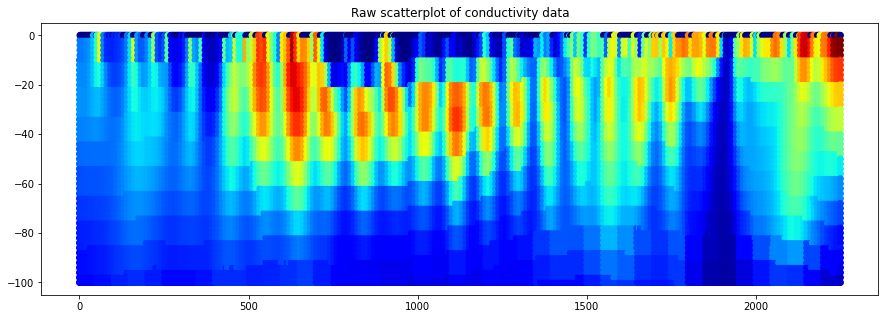

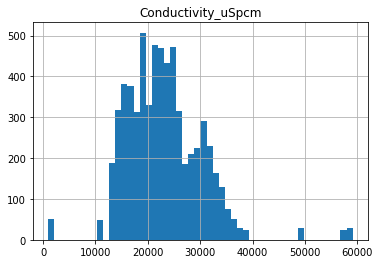

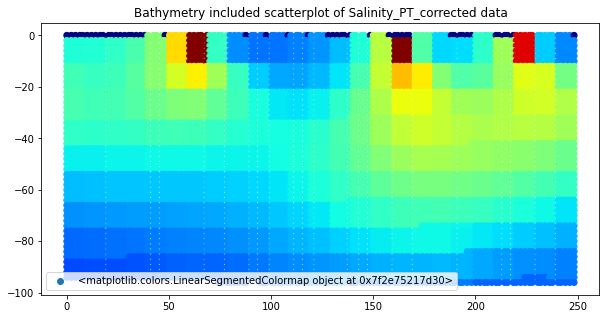

In [ ]:
# Step 1: Read in data 
data_L3aS2 = pd.read_csv(os.path.join(datapath, '3.Line3aSegment2MainPlume', "Line3a_Segment2.txt"), 
                   sep = " ", index_col=False)
# Execute function above
data1 = Read_in_resistivity_profile(data_L3aS2)


# zoom in on a specfic part of the profile
data_plume = data1.copy()
#data_plume = data_plume[(data_plume['Xdistance'] > 1765) & (data_plume['Xdistance'] < 2080) ]
data_plume = data_plume[(data_plume['Xdistance'] > 0) & (data_plume['Xdistance'] < 250) ]



# Check out histogram of data
data_plume.hist(column='Conductivity_uSpcm', bins=50)

# Read in bathydata and tack on data 
names = ["distance", "floor Depth"]
bathydata_in = pd.read_csv(os.path.join(bathydata_path, "Line3a_Segment 2_bathy.txt"),
                        delim_whitespace=True, usecols=[0,1], names=names, skiprows=1, index_col=False)

data_bath = Tack_on_Bathydata(data_plume, bathydata_in)



# Step 3 Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity_PT_corrected'] > 35, 'Salinity_PT_corrected'] = 35


# Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW = Calc_fractions_in_plume(data_bath, 2)

# save resulting points as shapefile
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "Line3a_Segment2_Small_plume.shp"), driver='ESRI Shapefile')  #write shapefile

# Step 6 Sanity check results
sanity_check(data5_Corrected)

# Append Results 
profile_name_list.append("Line3a_Segment2_Small_plume.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Just the small plume, and Problem as the length of the bathymetry file seems to be 2998.983900, whereas the resistivity corss section is 2249.581739")


# C: Execute analysis on 2.Line3c_Section1

SANITY CHECK
Percent of data that is unrealistically high salinity 24.83%
Percent of data that is crazy low salinity < 1 is 6.63%  

Back of envelope calculations to check validity: 
Profile Length is 1,849.3m, profile Depth is 38.0m 
Tot profile unit volumne   70,272.4m3 
Average profile salinity is 21.5, meaning average freshwater fraction is 0.3854
Total vol of FW (L x D x aveFWF) is  = 27,082.9 m3  


Compare to cell by cell calculated results:
Number of cells is 18,520.0 with mean volumne of 4.4
Tot profile unit volumne from adding cells  80,732.76m3 
Average freshwater fraction in the cell by cell profile is 0.39
Compare to cell by cell calculated total profile freshwater volume of 31,105.9m3


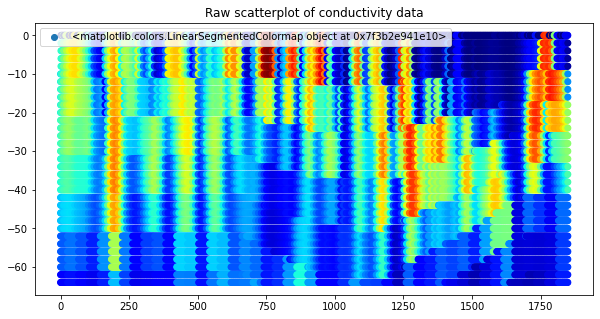

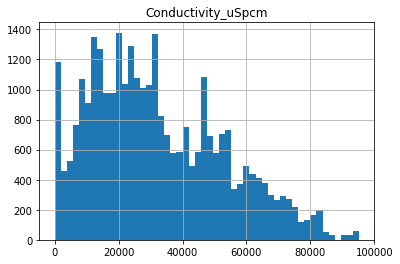

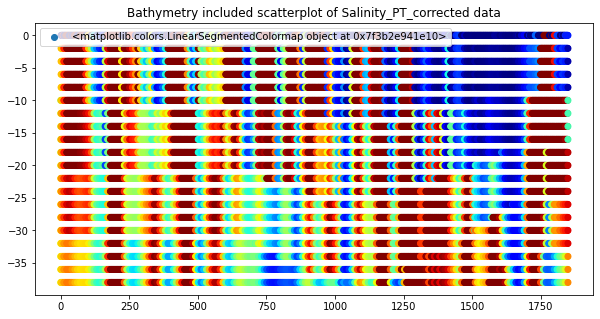

In [ ]:
# Step 1: Read in data 
data_L3cS1 = pd.read_csv(os.path.join(datapath, '2.Line3cSection1', "Line3c_Section1.txt"), 
                   sep = " ", index_col=False)

data1 = Read_in_resistivity_profile(data_L3cS1)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)


# Step 2: Read in bathydata and tack on data 
# Note: Can not find corresponding bathymetry file for this profile. for now cutting off anything deeper than 40 m
data_bath = data1[data1["D"] > -40 ]



# Step 3: sanity checks and fix over salinity values
# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity_PT_corrected'] > 35, 'Salinity_PT_corrected'] = 35


# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)


# save resulting points as shapefile
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "Line3c_Section1_Profile.shp"), driver='ESRI Shapefile')  #write shapefile

# Step 6 Sanity check results
sanity_check(data5_Corrected)

# Append Results 
profile_name_list.append("Line3c_Section1_Profile.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Can not find corresponding bathymetry file for this profile. for now cutting off anything deeper than 40 m")

# D: Execute analysis on 4. Line3a_Segment1

SANITY CHECK
Percent of data that is unrealistically high salinity 11.50%
Percent of data that is crazy low salinity < 1 is 2.60%  

Back of envelope calculations to check validity: 
Profile Length is 2,199.6m, profile Depth is 92.0m 
Tot profile unit volumne   202,362.9m3 
Average profile salinity is 21.9, meaning average freshwater fraction is 0.3745
Total vol of FW (L x D x aveFWF) is  = 75,784.0 m3  


Compare to cell by cell calculated results:
Number of cells is 50,402.0 with mean volumne of 4.2
Tot profile unit volumne from adding cells  212,308.95m3 
Average freshwater fraction in the cell by cell profile is 0.37
Compare to cell by cell calculated total profile freshwater volume of 79,500.9m3


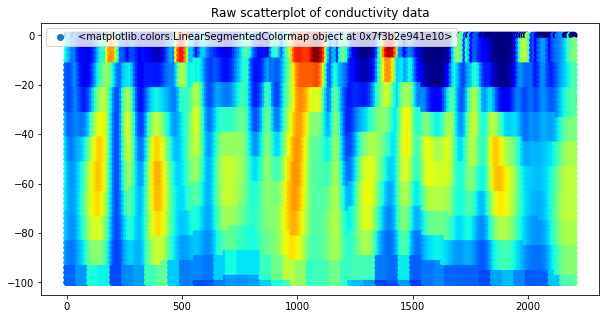

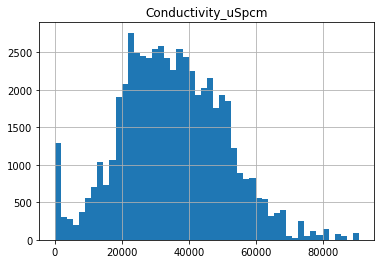

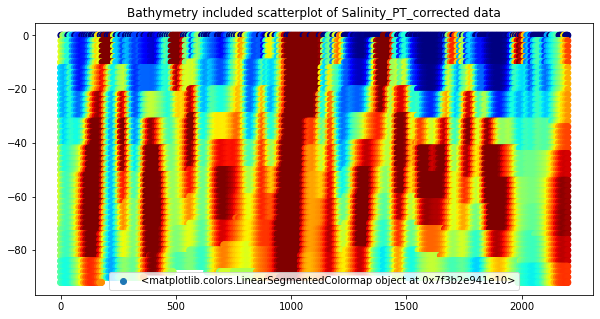

In [ ]:
# Step 1: Read in data 
data_4L3aS1 = pd.read_csv(os.path.join(datapath, '4.Line3aSegment1', "Line3a_Segment1.txt"), 
                   sep = " ", index_col=False)

data1 = Read_in_resistivity_profile(data_4L3aS1)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)


# Step 2: Read in bathydata and tack on data 
names = ["distance", "floor Depth"]
bathydata_in = pd.read_csv(os.path.join(bathydata_path, "Line3a_Segment 1 - CSEM_model_NOT_used_in_paper.txt"),
                        delim_whitespace=True, usecols=[0,1], names=names, skiprows=1, index_col=False)

data_bath = Tack_on_Bathydata(data1, bathydata_in)


# Step 3: sanity checks and fix over salinity values
# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity_PT_corrected'] > 35, 'Salinity_PT_corrected'] = 35


# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)

# save resulting points as shapefile
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "4pLine3a_Segment 1_Profile.shp"), driver='ESRI Shapefile')  #write shapefile

# Step 6 Sanity check results
sanity_check(data5_Corrected)

# Append Results 
profile_name_list.append("4pLine3a_Segment 1_Profile.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Apparently this one is not used in the paper")

# E: Execute analysis on  1.Line1 - Section 1

SANITY CHECK
Percent of data that is unrealistically high salinity 1.23%
Percent of data that is crazy low salinity < 1 is 3.29%  

Back of envelope calculations to check validity: 
Profile Length is 2,500.3m, profile Depth is 24.0m 
Tot profile unit volumne   60,007.0m3 
Average profile salinity is 12.1, meaning average freshwater fraction is 0.6536
Total vol of FW (L x D x aveFWF) is  = 39,219.8 m3  


Compare to cell by cell calculated results:
Number of cells is 16,263.0 with mean volumne of 4.5
Tot profile unit volumne from adding cells  72,615.05m3 
Average freshwater fraction in the cell by cell profile is 0.65
Compare to cell by cell calculated total profile freshwater volume of 47,445.6m3


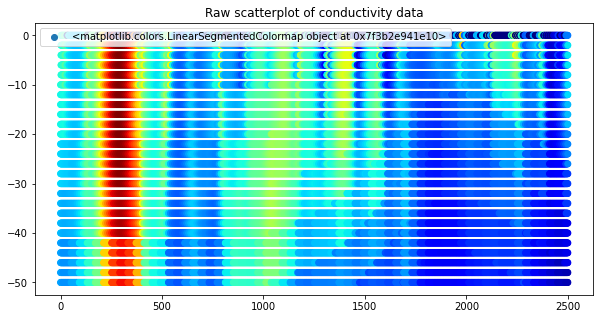

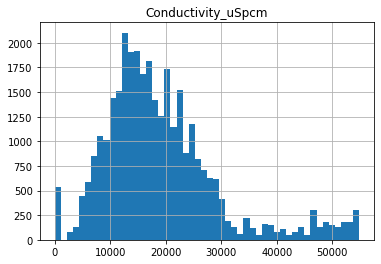

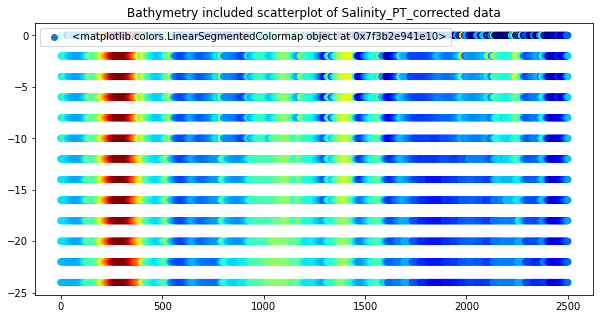

In [ ]:
# Step 1: Read in data 
data_1L1aS1 = pd.read_csv(os.path.join(datapath, '1.Line1 - Section 1', "Line1_Section1.txt"), 
                   sep = " ", index_col=False)

data1 = Read_in_resistivity_profile(data_1L1aS1)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)



# Step 2: Read in bathydata and tack on data 
# Note: Can not find corresponding bathymetry file for this profile. for now cutting off anything deeper than 25 m
data_bath = data1[data1["D"] > -25 ]


# Step 3: sanity checks and fix over salinity values
# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity_PT_corrected'] > 35, 'Salinity_PT_corrected'] = 35

# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)


# save resulting points as shapefile
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "4pLine3a_Segment 1_Profile.shp"), driver='ESRI Shapefile')  #write shapefile

# Step 6 Sanity check results
sanity_check(data5_Corrected)

# Append Results 
profile_name_list.append("4pLine3a_Segment 1_Profile.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Can not find corresponding bathymetry file for this profile. for now cutting off anything deeper than 25 m")

In [ ]:
##### OLD results before PT correctiong   #########

,Profile,Total_FW_1m_UnitWidth_m3,%FW_in_profile,Notes,Tot_FW_VOL_Wide_Profile,Profile_FLUX_m3pd
0,Line3a_Segment2_Profile.shp,"212,825",45,Problem as the length of the bathymetry file s...,"10,641,236","10,641,236"
1,Line3a_Segment2_Small_plume.shp,"26,053",51,"Just the small plume, and Problem as the lengt...","1,302,660","1,302,660"
2,Line3c_Section1_Profile.shp,"80,733",38,Can not find corresponding bathymetry file for...,"4,036,638","4,036,638"
3,4pLine3a_Segment 1_Profile.shp,"212,309",37,Apparently this one is not used in the paper,"10,615,447","10,615,447"
4,4pLine3a_Segment 1_Profile.shp,"72,615",65,Can not find corresponding bathymetry file for...,"3,630,753","3,630,753"


In [ ]:
# Compile results
Results_Frame = pd.DataFrame({"Profile":profile_name_list , "Total_FW_1m_UnitWidth_m3":Tot_vol_FW_1m_rez_list, "%FW_in_profile":pct_FW_list, "Notes":Notes_List})

# Set caclulation Parameters 

# Set residence time  (one day is very conservative)
Residence_time_days = 1

# Set assumed profile width  (50 to 100 m???)
Profile_width = 50


# Set up the flux calculations

Results_Frame['Tot_FW_VOL_Wide_Profile'] = Results_Frame['Total_FW_1m_UnitWidth_m3']*Profile_width

Results_Frame['Profile_FLUX_m3pd'] = Results_Frame['Tot_FW_VOL_Wide_Profile']/Residence_time_days




Results_Frame

,Profile,Total_FW_1m_UnitWidth_m3,%FW_in_profile,Notes,Tot_FW_VOL_Wide_Profile,Profile_FLUX_m3pd
0,Line3a_Segment2_Profile.shp,"212,824.711",44.989,Problem as the length of the bathymetry file s...,"10,641,235.537","10,641,235.537"
1,Line3a_Segment2_Small_plume.shp,"26,053.199",51.419,"Just the small plume, and Problem as the lengt...","1,302,659.948","1,302,659.948"
2,Line3c_Section1_Profile.shp,"80,732.764",38.529,Can not find corresponding bathymetry file for...,"4,036,638.217","4,036,638.217"
3,4pLine3a_Segment 1_Profile.shp,"212,308.948",37.446,Apparently this one is not used in the paper,"10,615,447.389","10,615,447.389"
4,4pLine3a_Segment 1_Profile.shp,"72,615.052",65.339,Can not find corresponding bathymetry file for...,"3,630,752.594","3,630,752.594"


In [ ]:
data5_Corrected

,E,N,D,Resistivity,Salinity,Conductivity_uSpcm,Pressure_dBar,Est_temp_degC,Salinity_PT_corrected,Xdistance,Xdistance_int,datumXdistance,cell_height,dA,dB,cell_width,cell_unit_area,cell_FW_fraction,cell_FW_volume_m3,geometry
0,822310,2200291,0,nan,nan,nan,0.000,27.500,nan,0.000,0,0.000,2,1.118,nan,2.233,4.465,nan,nan,POINT (0.000 0.000)
1,822309,2200289,0,0.470,12.745,"21,272.070",0.000,27.500,12.711,2.236,2,2.236,2,0.685,1.118,2.233,4.465,0.637,2.844,POINT (2.236 0.000)
2,822308,2200288,0,0.470,12.745,"21,272.070",0.000,27.500,12.711,3.606,4,3.606,2,1.113,0.685,2.233,4.465,0.637,2.844,POINT (3.606 0.000)
3,822307,2200286,0,0.470,12.745,"21,272.070",0.000,27.500,12.711,5.831,6,5.831,2,1.116,1.113,2.233,4.465,0.637,2.844,POINT (5.831 0.000)
4,822306,2200284,0,0.470,12.745,"21,272.070",0.000,27.500,12.711,8.062,8,8.062,2,1.117,1.116,2.233,4.465,0.637,2.844,POINT (8.062 0.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246,821072,2198128,-24,0.817,6.995,"12,236.907",23.512,25.820,6.973,"2,492.231",2492,"2,492.231",2,0.682,1.116,2.233,4.465,0.801,3.575,POINT (2492.231 -24.000)
1247,821071,2198127,-24,0.817,6.995,"12,236.907",23.512,25.820,6.973,"2,493.595",2494,"2,493.595",2,1.116,0.682,2.233,4.465,0.801,3.575,POINT (2493.595 -24.000)
1248,821070,2198125,-24,0.817,6.995,"12,236.907",23.512,25.820,6.973,"2,495.828",2496,"2,495.828",2,1.116,1.116,2.233,4.465,0.801,3.575,POINT (2495.828 -24.000)
1249,821069,2198123,-24,0.817,6.995,"12,236.907",23.512,25.820,6.973,"2,498.060",2498,"2,498.060",2,1.116,1.116,2.233,4.465,0.801,3.575,POINT (2498.060 -24.000)
